<a href="https://colab.research.google.com/github/lejdak/AMD-MarketBasketAnalysis/blob/main/AmazonMarketBasket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Global imports and configuration

In [1]:
# Install
!pip install -q pyspark kaggle findspark
!mkdir -p ~/.kaggle

In [2]:
import os
import math
import hashlib
import itertools
import zlib
import findspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark import StorageLevel
from pyspark.sql.functions import lower, regexp_replace, trim, collect_set, size, first, col, length

In [3]:
# authenticate Kaggle
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"

# download dataset
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

# unzip the dataset
!unzip -q amazon-books-reviews.zip
print("Dataset downloaded and extracted.")

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 98% 1.04G/1.06G [00:15<00:00, 44.7MB/s]
100% 1.06G/1.06G [00:15<00:00, 72.0MB/s]
Dataset downloaded and extracted.


## Initialize Spark session

In [4]:
# start Spark
findspark.init()
spark = (
    SparkSession.builder
    .appName("AmazonMarketBasket")
    .master("local[*]")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

## Data raw loading
We load the dataset once here. It will be reused for both Task A and Task B.

In [5]:
# load Data
df_raw = spark.read.csv(
    "Books_rating.csv",
    header=True,
    inferSchema=True,
    multiLine=True,    # Crucial for reviews
    quote='"',
    escape='"'
)
print("Initial schema:")
df_raw.printSchema()
df_raw.show(3, truncate=120)
df_raw.count()

Initial schema:
root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: double (nullable = true)
 |-- review/time: integer (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

+----------+------------------------------+-----+--------------+---------------------+------------------+------------+-----------+-----------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|        Id|                         Title|Price|       User_id|          profileName|review/helpfulness|review/score|review/time|                                 review/summary|                                                                                   

3000000

## **TASK A (WORDS AS ITEMS)**
# Preprocessing
The goal is to find frequent words and word associations using the SON Algorithm.

In [6]:
# Configuration
# Set to False to attempt running on the full dataset
USE_SUBSAMPLE = True
SUBSAMPLE_FRACTION = 0.02 # 2% Sample

In [7]:
# 1. Select columns
df_text = df_raw.select("Id", F.col("review/text").alias("review_text")).na.drop()

# Sampling
# we sample specifically for the text analysis to keep execution time reasonable
if USE_SUBSAMPLE:
    print(f"Sampling {SUBSAMPLE_FRACTION*100}% of reviews")
    df_text = df_text.sample(withReplacement=False, fraction=SUBSAMPLE_FRACTION, seed=42)

Sampling 2.0% of reviews


In [8]:
# 2. RegexTokenizer: splits text into words, removes punctuation, filters short words (<3 chars)
tokenizer = RegexTokenizer(inputCol="review_text", outputCol="raw_tokens", pattern="\\W+", toLowercase=True, minTokenLength=3)
# StopWordsRemover: removes common english words (the, and, is, etc.)
remover = StopWordsRemover(inputCol="raw_tokens", outputCol="filtered_tokens")
# apply transformation
df_processed = remover.transform(tokenizer.transform(df_text))

In [9]:
# 3. Create Baskets
# We use array_distinct because Market Basket Analysis checks for presence (0/1), not frequency
df_word_baskets = (
    df_processed.select(F.array_distinct("filtered_tokens").alias("items"))
    .filter(F.size("items") >= 2) # Remove baskets with fewer than 2 words
)

# Convert to RDD for the SON Algorithm
word_baskets_rdd = df_word_baskets.rdd.map(lambda row: set(row['items']))
word_baskets_rdd.cache()

print(f"Word Baskets Created: {word_baskets_rdd.count()}")

Word Baskets Created: 60322


## SON algorithm
We define the MapReduce function:
- Phase 1: Find Local Frequent Itemsets (Singletons, Pairs, Triplets).
- Phase 2: Verify Global Support counts.

In [10]:
# Configuration
MIN_SUPPORT_RATE_WORDS = 0.01  # 1% Support Threshold
MAX_ITEMS_PER_BASKET = 25      # Safety valve for k=3 calculation

total_baskets_words = word_baskets_rdd.count()
min_support_count_words = int(total_baskets_words * MIN_SUPPORT_RATE_WORDS)

print(f"Global Threshold: {min_support_count_words} occurrences")

Global Threshold: 603 occurrences


SON functions

In [11]:
def son_phase1_local(iterator):
    """Local A-Priori (Map Phase 1)"""
    baskets = list(iterator)
    if not baskets: return []

    local_threshold = math.ceil(len(baskets) * MIN_SUPPORT_RATE_WORDS)

    # L1: Singles
    counts = defaultdict(int)
    for basket in baskets:
        for item in basket: counts[frozenset([item])] += 1
    freq_singles = {k for k, v in counts.items() if v >= local_threshold}
    freq_flat = {list(x)[0] for x in freq_singles}
    for item in freq_singles: yield item

    # L2 & L3: Pairs and Triplets
    counts_pairs, counts_triples = defaultdict(int), defaultdict(int)

    for basket in baskets:
        # only consider words that were locally frequent as singles
        relevant = [item for item in basket if item in freq_flat]

        # Safety Valve: limit basket size to prevent combinatorial explosion
        if len(relevant) > MAX_ITEMS_PER_BASKET:
            relevant = sorted(relevant)[:MAX_ITEMS_PER_BASKET]
        else:
            relevant = sorted(relevant)

        for pair in itertools.combinations(relevant, 2):
            counts_pairs[frozenset(pair)] += 1

        if len(relevant) >= 3:
            for triple in itertools.combinations(relevant, 3):
                counts_triples[frozenset(triple)] += 1

    for pair, c in counts_pairs.items():
        if c >= local_threshold: yield pair
    for triple, c in counts_triples.items():
        if c >= local_threshold: yield triple

In [12]:
def son_phase2_global(iterator, candidates):
    """Global Counting (Map Phase 2)"""
    local_counts = defaultdict(int)
    baskets = list(iterator)
    for basket in baskets:
        basket_set = set(basket)
        for cand in candidates:
            if cand.issubset(basket_set):
                local_counts[cand] += 1
    return local_counts.items()

print("SON Functions Defined.")

SON Functions Defined.


## Executing the algorithm
Phase 1: candidate generation

In [13]:
# Phase 1: Candidates
candidates = word_baskets_rdd.mapPartitions(son_phase1_local).distinct().collect()
print(f"Phase 1: Found {len(candidates)} candidates.")

Phase 1: Found 2779 candidates.


Phase 2: global counting

In [14]:
# Phase 2: Global Counts
cand_bc = spark.sparkContext.broadcast(candidates)
global_counts = word_baskets_rdd.mapPartitions(lambda x: son_phase2_global(x, cand_bc.value)) \
                                .reduceByKey(lambda a, b: a + b)

In [15]:
# Final Filter
frequent_words = global_counts.filter(lambda x: x[1] >= min_support_count_words).collect()
print(f"Found {len(frequent_words)} confirmed frequent itemsets.")

Found 2779 confirmed frequent itemsets.


## Results and Visualization
For visualization, we first process results into Pandas

In [16]:
data_res = []
for itemset, count in frequent_words:
    data_res.append({
        "Itemset": ", ".join(sorted(list(itemset))),
        "Size": len(itemset),
        "Occurrences": count,
        "Support (%)": (count / total_baskets_words) * 100
    })
df_words_res = pd.DataFrame(data_res)

In [17]:
# define plotting function
sns.set_theme(style="whitegrid")

def analyze_and_plot(df, k, color, title):
    # filter Top 10
    subset = df[df["Size"] == k].sort_values("Occurrences", ascending=False).head(10).copy()

    # table view
    print(f"\n{'='*60}\n{title}\n{'='*60}")
    display(subset[["Itemset", "Occurrences", "Support (%)"]].style.format({
        "Occurrences": "{:,}",
        "Support (%)": "{:.2f}%"
    }).hide(axis="index"))

    # chart view
    plt.figure(figsize=(10, 4))
    ax = sns.barplot(data=subset, x="Support (%)", y="Itemset", color=color, edgecolor="black")
    ax.bar_label(ax.containers[0], fmt='%.1f%%', padding=3)
    plt.title(title, fontsize=12, weight='bold')
    plt.xlabel("Support (%)")
    plt.ylabel("")
    plt.show()


Top 10 Frequent Single Words


Itemset,Occurrences,Support (%)
book,"45,565",75.54%
read,"28,726",47.62%
one,"22,327",37.01%
like,"15,680",25.99%
story,"14,459",23.97%
good,"13,519",22.41%
time,"13,339",22.11%
great,"13,053",21.64%
reading,"12,576",20.85%
well,"12,435",20.61%


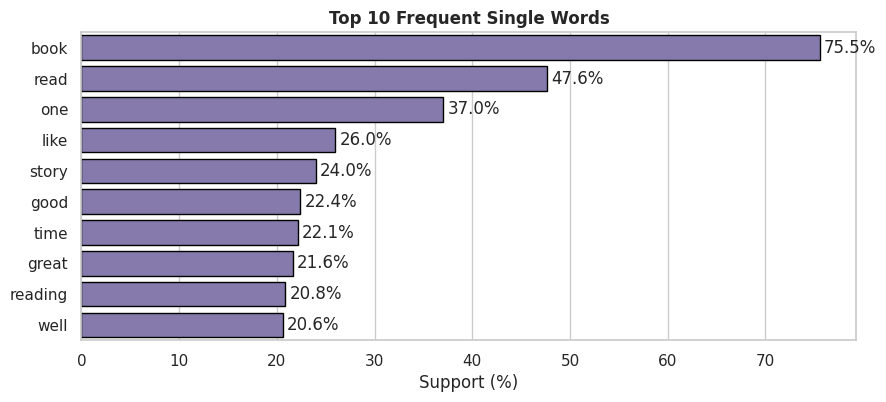


Top 10 Frequent Word Pairs


Itemset,Occurrences,Support (%)
"book, read","23,463",38.90%
"book, one","17,532",29.06%
"book, like","12,900",21.39%
"one, read","12,562",20.82%
"book, good","11,088",18.38%
"book, story","10,992",18.22%
"book, time","10,759",17.84%
"book, reading","10,542",17.48%
"book, great","10,514",17.43%
"book, well","10,119",16.77%


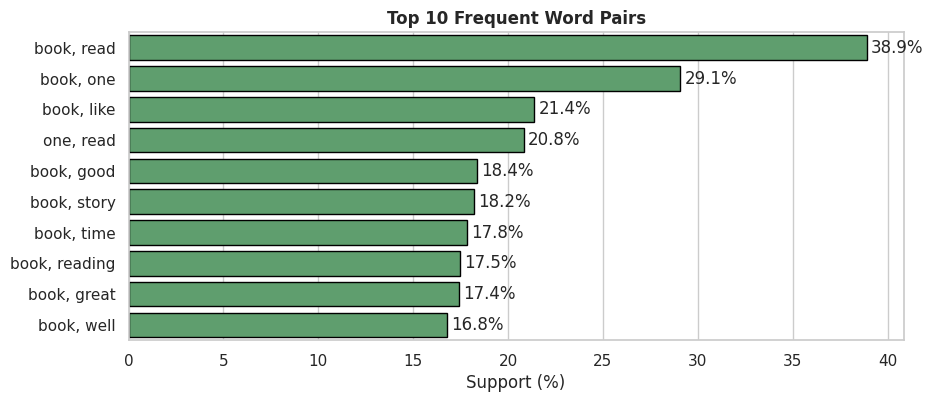


Top 10 Frequent Word Triplets


Itemset,Occurrences,Support (%)
"book, one, read","10,514",17.43%
"book, like, read","7,658",12.70%
"book, read, story","6,875",11.40%
"book, read, reading","6,669",11.06%
"book, read, time","6,649",11.02%
"book, like, one","6,544",10.85%
"book, books, read","6,543",10.85%
"book, first, read","6,394",10.60%
"book, good, read","6,276",10.40%
"book, books, one","5,916",9.81%


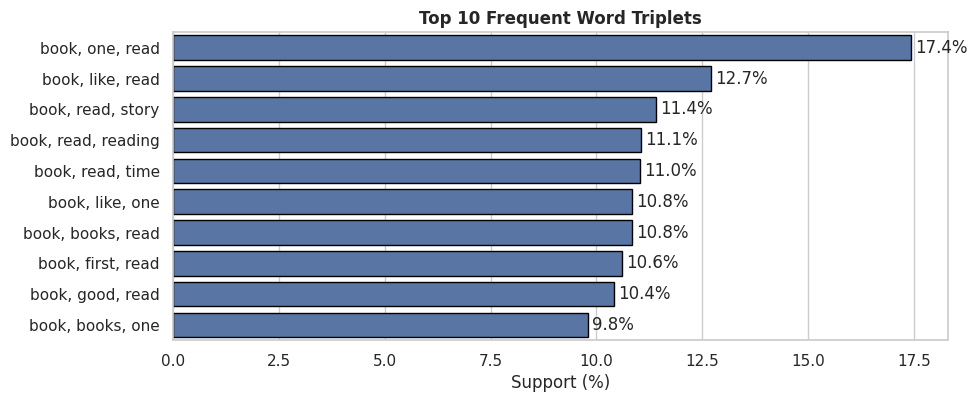

In [18]:
# generate reports
analyze_and_plot(df_words_res, k=1, color="#8172b3", title="Top 10 Frequent Single Words")
analyze_and_plot(df_words_res, k=2, color="#55a868", title="Top 10 Frequent Word Pairs")
analyze_and_plot(df_words_res, k=3, color="#4c72b0", title="Top 10 Frequent Word Triplets")

## Association rules generation

In [19]:
# prepare single support map for calculations
# we need the support of 'A' to calculate Confidence(A->B)
singles_map = df_words_res[df_words_res["Size"] == 1].set_index(
    df_words_res[df_words_res["Size"] == 1]["Itemset"]
)["Support (%)"].to_dict()

In [20]:
# filter pairs (Size 2)
pairs = df_words_res[df_words_res["Size"] == 2].copy()
rules_list = []

In [21]:
# calculate confidence and lift
for _, row in pairs.iterrows():
    # split "word1, word2" back into list
    items = row["Itemset"].split(", ")
    item_A, item_B = items[0], items[1]

    # check if we have support data
    if item_A in singles_map and item_B in singles_map:
        support_AB = row["Support (%)"] / 100
        support_A = singles_map[item_A] / 100
        support_B = singles_map[item_B] / 100

        # Rule A -> B
        conf_A = support_AB / support_A
        lift_A = conf_A / support_B
        rules_list.append([item_A, item_B, support_AB, conf_A, lift_A])

        # Rule B -> A
        conf_B = support_AB / support_B
        lift_B = conf_B / support_A
        rules_list.append([item_B, item_A, support_AB, conf_B, lift_B])

In [22]:
# display rules
df_rules = pd.DataFrame(rules_list, columns=["Antecedent", "Consequent", "Support", "Confidence", "Lift"])
top_rules = df_rules.sort_values(by="Lift", ascending=False).head(10)


print("TOP 10 ASSOCIATION RULES (Sorted by Lift)")
display(top_rules.style.format({
    "Support": "{:.2%}",
    "Confidence": "{:.2%}",
    "Lift": "{:.2f}"
}).hide(axis="index"))

TOP 10 ASSOCIATION RULES (Sorted by Lift)


Antecedent,Consequent,Support,Confidence,Lift
highly,recommend,3.30%,51.38%,4.80
recommend,highly,3.30%,30.80%,4.80
recommend,anyone,2.78%,25.97%,2.87
anyone,recommend,2.78%,30.76%,2.87
character,characters,3.42%,40.02%,2.71
characters,character,3.42%,23.09%,2.71
ever,best,3.31%,33.18%,2.66
best,ever,3.31%,26.53%,2.66
characters,novel,4.63%,31.31%,2.57
novel,characters,4.63%,37.99%,2.57


## **TASK B (BOOKS AS ITEMS)**
# Preprocessing

In [23]:
# Configuration
USE_SUBSAMPLE_BOOKS = True       # True while developing, False for final run
SUBSAMPLE_FRACTION_BOOKS = 0.02   # Sample 2% of users while developing

In [24]:
# 1. Load relevant columns and drop nulls
df_books = df_raw.select("User_id", "Id", "Title").na.drop()

In [25]:
# 2. title cleaning and normalization
# We clean titles to ensure "The Hobbit" and "The Hobbit (Illustrated)" are treated as the same book.
# We remove brackets, punctuation, and extra spaces.
df_books = (df_books
            .withColumn("Title_Clean", lower(col("Title")))
            .withColumn("Title_Clean", regexp_replace("Title_Clean", r"\[.*?\]|\(.*?\)", " "))
            .withColumn("Title_Clean", regexp_replace("Title_Clean", r"[^a-z0-9\s]", " "))
            .withColumn("Title_Clean", regexp_replace("Title_Clean", r"\s+", " "))
            .withColumn("Title_Clean", trim(col("Title_Clean")))
           )

# filter empty cleans
df_books = df_books.filter(length(col("Title_Clean")) > 1)

In [26]:
# 3. canonical IDs
# we assign a single ID (the first one seen) to represent a Clean Title.
# this fixes the issue of multiple product IDs referring to the same book edition.
df_unique_ids = df_books.groupBy("Title_Clean").agg(first("Id").alias("Canonical_Id"))

In [27]:
# join back to each row, so every row has Canonical_Id
df_merged = df_books.join(df_unique_ids, on="Title_Clean", how="left") \
                    .select("User_id", col("Canonical_Id").alias("Id"), "Title")

In [28]:
#  Sampling (if enabled)
if USE_SUBSAMPLE_BOOKS:
    print(f"Sampling {SUBSAMPLE_FRACTION_BOOKS*100:.2f}% of rows for development")
    df_merged = df_merged.sample(False, SUBSAMPLE_FRACTION_BOOKS, seed=42)

Sampling 2.00% of rows for development


In [29]:
# persist to Memory+Disk to handle large data volume
df_merged = df_merged.persist(StorageLevel.MEMORY_AND_DISK)
df_merged.count()

48864

In [30]:
# 4. build user baskets
df_book_baskets = (df_merged
                   .groupBy("User_id")
                   .agg(F.collect_set("Id").alias("items"))
                   .filter(F.size("items") >= 2)) # Users who reviewed at least 2 books

In [31]:
# Convert to RDD
book_baskets_rdd = df_book_baskets.rdd.map(lambda r: set(r['items']))
book_baskets_rdd = book_baskets_rdd.persist(StorageLevel.MEMORY_AND_DISK)

total_baskets_books = book_baskets_rdd.count()
print("Total book baskets (users):", total_baskets_books)

Total book baskets (users): 3032


# MULTISTAGE ALGORITHM


In [32]:
#Configuration
MIN_SUPPORT_RATE_BOOKS = 0.001    # 0.1% Threshold
NUM_BUCKETS1 = 20000              # Pass 2 Hash Table Size
NUM_BUCKETS2 = 20000              # Pass 3 Hash Table Size
thresh_books = max(1, int(total_baskets_books * MIN_SUPPORT_RATE_BOOKS))

print(f"Global Support Threshold (Books): {thresh_books} occurrences")

Global Support Threshold (Books): 3 occurrences


In [33]:
#Hash helper function
def stable_hash_key(pair, num_buckets, salt):
    """Deterministic hashing for pairs using blake2b"""
    key = (pair[0] + "||" + pair[1]).encode("utf-8")
    h = hashlib.blake2b(key, digest_size=8, person=salt.encode("utf-8"))
    return int.from_bytes(h.digest(), "big") % num_buckets

In [34]:
# PASS 1: count singles (L1) and create bitmap1 from hashing all pairs
print("1. Pass 1: Finding frequent single books")
singles_counts_rdd = book_baskets_rdd.flatMap(lambda b: [(i, 1) for i in b]) \
                                     .reduceByKey(lambda a, b: a + b)

# Filter frequent singles
frequent_singles = singles_counts_rdd.filter(lambda x: x[1] >= thresh_books) \
                                     .map(lambda x: x[0]) \
                                     .collect()
print(f"Found {len(frequent_singles)} frequent singles.")
bc_singles = spark.sparkContext.broadcast(set(frequent_singles))

1. Pass 1: Finding frequent single books
Found 504 frequent singles.


In [35]:
#PASS 2- first hashing: generate bucket counts for all pairs (only pairs where both items are frequent),
# we make sure we only hash pairs of frequent singles (this reduces counts)
print("2. Pass 2: Hashing pairs into first table")
def map_pairs_to_buckets1(basket):
    valid = [i for i in basket if i in bc_singles.value]
    valid.sort()
    for a, b in itertools.combinations(valid, 2):
        idx = stable_hash_key((a, b), NUM_BUCKETS1, "stage1")
        yield (idx, 1)

buckets1 = book_baskets_rdd.flatMap(map_pairs_to_buckets1).reduceByKey(lambda a,b: a+b)
# Keep only buckets with count >= thresh
bitmap1 = set(buckets1.filter(lambda x: x[1] >= thresh_books).map(lambda x: x[0]).collect())
print(f"Bitmap 1 Size (Frequent Buckets): {len(bitmap1)}")
# Broadcast bitmap1
bc_bitmap1 = spark.sparkContext.broadcast(bitmap1)

2. Pass 2: Hashing pairs into first table
Bitmap 1 Size (Frequent Buckets): 67


In [36]:
# PASS 3 - second hashing: hash again into second table, but only hash pairs that:
# (i) are composed of frequent singles and (ii) hashed to frequent bucket in pass1
print("3. Pass 3: Hashing pairs into second table")
def map_pairs_to_buckets2(basket):
    valid = [i for i in basket if i in bc_singles.value]
    valid.sort()
    for a, b in itertools.combinations(valid, 2):
        idx1 = stable_hash_key((a, b), NUM_BUCKETS1, "stage1")
        if idx1 in bc_bitmap1.value:
            idx2 = stable_hash_key((a, b), NUM_BUCKETS2, "stage2")
            yield (idx2, 1)

buckets2 = book_baskets_rdd.flatMap(map_pairs_to_buckets2).reduceByKey(lambda a,b: a+b)
bitmap2 = set(buckets2.filter(lambda x: x[1] >= thresh_books).map(lambda x: x[0]).collect())
print(f"Bitmap 2 Size (Frequent Buckets): {len(bitmap2)}")
bc_bitmap2 = spark.sparkContext.broadcast(bitmap2)

3. Pass 3: Hashing pairs into second table
Bitmap 2 Size (Frequent Buckets): 56


In [37]:
# PASS 4: Final counting of candidate pairs that pass both bitmaps
print("4. Final Pass: Counting candidate pairs")
def map_final_pairs(basket):
    valid = [i for i in basket if i in bc_singles.value]
    valid.sort()
    for a, b in itertools.combinations(valid, 2):
        idx1 = stable_hash_key((a, b), NUM_BUCKETS1, "stage1")
        if idx1 not in bc_bitmap1.value: continue

        idx2 = stable_hash_key((a, b), NUM_BUCKETS2, "stage2")
        if idx2 not in bc_bitmap2.value: continue

        yield ((a, b), 1)

final_pairs_counts = book_baskets_rdd.flatMap(map_final_pairs) \
                                     .reduceByKey(lambda a,b: a+b) \
                                     .filter(lambda x: x[1] >= thresh_books) \
                                     .collect()

print(f"Number of frequent pairs found: {len(final_pairs_counts)}")

4. Final Pass: Counting candidate pairs
Number of frequent pairs found: 56


#Results and visualization

In [38]:
# map results back to Titles for readability
# Build a small DataFrame with unique canonical id -> representative title
df_product_map = df_merged.select(F.col("Id").alias("Canonical_Id"), F.col("Title")).dropDuplicates(['Canonical_Id'])
# collect small mapping for final pretty printing (should be reasonably sized)
prod_map_local = dict(df_product_map.rdd.map(lambda r: (r['Canonical_Id'], r['Title'])).collect())

In [39]:
# build result DataFrame
data_pairs = []
for (idA, idB), count in final_pairs_counts:
    data_pairs.append({
        "ID_A": idA,
        "Book_A": prod_map_local.get(idA, "Unknown"),
        "ID_B": idB,
        "Book_B": prod_map_local.get(idB, "Unknown"),
        "Occurrences": count,
        "Support": count / total_baskets_books
    })

df_pairs_b = pd.DataFrame(data_pairs).sort_values("Occurrences", ascending=False)

# Visualize with Style
print("TOP 20 FREQUENT BOOK PAIRS (Multistage Results)")


display(df_pairs_b.head(20).style.format({
    "Occurrences": "{:,}",
    "Support": "{:.4%}"  # 4 decimals for high precision on small book support
}).hide(axis="index"))

TOP 20 FREQUENT BOOK PAIRS (Multistage Results)


ID_A,Book_A,ID_B,Book_B,Occurrences,Support
0435126075,Pride & Prejudice (New Windmill),1844560333,Pride and Prejudice,22,0.7256%
B000GQG5MA,"The Hobbit; Or, There and Back Again",B000NDSX6C,The Hobbit,21,0.6926%
0736641238,Little Women,B0008BL2SA,"Little women; or, Meg, Jo, Beth, and Amy,",17,0.5607%
B000HIGLBW,The Scarlet Letter,B000N6DDJQ,The Scarlet Letter A Romance,12,0.3958%
B000ILIJE0,The Hobbit There and Back Again,B000NDSX6C,The Hobbit,11,0.3628%
0192839020,A Connecticut Yankee in King Arthur's Court (Oxford World's Classics),B000FOENMW,Life on the Mississippi,9,0.2968%
0435126083,Wuthering Heights (New Windmill),B000FFQ85G,Jane Eyre / Wuthering Heights,9,0.2968%
0435126083,Wuthering Heights (New Windmill),1844560333,Pride and Prejudice,8,0.2639%
019283357X,Emma (World's Classics),1844560333,Pride and Prejudice,7,0.2309%
0140351310,Jane Eyre: Complete and Unabridged (Puffin Classics),1587263971,Jane Eyre,7,0.2309%
